In [1]:
import os
import random
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split, Subset
import torchvision.transforms as transforms
from torchvision.models import resnet18
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold

In [20]:
class CustomMultimodalDataset(Dataset):
    """
    Loads sensor data and corresponding images from a CSV file.
    """
    def __init__(self, csv_file, image_dir, transform=None):
        # Read the CSV file
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        
        # Use the exact column names from the CSV file with underscores
        self.sensor_columns = [
            'moisture_value', 'moisture_percentage',
            'ph_ph_value', 'ph_depth', 'ph_light', 'ph_temperature',
            'npk_nitrogen', 'npk_phosphorus', 'npk_potassium'
        ]
        
        # Print column names for verification
        print(f"CSV columns: {list(self.data.columns)}")
        try:
            print(f"First row sample: {self.data.iloc[0][self.sensor_columns]}")
            print(f"Dataset loaded successfully with {len(self.data)} samples")
        except Exception as e:
            print(f"Error accessing columns: {e}")

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        
        # Convert sensor readings to a float tensor
        sensor_values = row[self.sensor_columns].values.astype(np.float32)
        sensor_tensor = torch.tensor(sensor_values)
        
        # Load image using the image_filename column
        img_path = os.path.join(self.image_dir, row['image_filename'])
        try:
            image = Image.open(img_path).convert('RGB')
            if self.transform:
                image = self.transform(image)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")
            # Fallback to empty tensor if image loading fails
            image = torch.zeros((3, 224, 224))
        
        # For classification task - use a dummy label (0) since we don't have explicit labels
        # In a real scenario, we would use actual labels from the dataset
        # For this example, we're creating synthetic labels based on NPK values
        # This creates 3 classes based on potassium levels
        if row['npk_potassium'] <= 3:
            label = 0
        elif row['npk_potassium'] <= 7:
            label = 1
        else:
            label = 2
        
        return sensor_tensor, image, label


In [3]:
image_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [25]:
# 1. MDFCL Model: Multi-modal Data Fusion via Contrastive Learning
class MDFCLModel(nn.Module):
    def __init__(self, sensor_input_dim, num_classes):
        super(MDFCLModel, self).__init__()
        # Sensor branch: MLP encoder
        self.sensor_fc = nn.Sequential(
            nn.Linear(sensor_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU()
        )
        # Image branch: ResNet encoder
        self.image_encoder = resnet18(weights="IMAGENET1K_V1")
        self.image_encoder.fc = nn.Identity()  # Remove final classifier
        
        # Fusion classifier
        self.classifier = nn.Sequential(
            nn.Linear(32 + 512, 128),  # Concatenated features
            nn.ReLU(),
            nn.Dropout(0.3),  # Add dropout for regularization
            nn.Linear(128, num_classes)
        )
        
    def forward(self, sensor, image):
        sensor_feat = self.sensor_fc(sensor)           # [batch, 32]
        image_feat = self.image_encoder(image)         # [batch, 512]
        fused = torch.cat([sensor_feat, image_feat], dim=1)
        return self.classifier(fused)

In [26]:
# 2. GSIFN Model: Graph-Structured & Interlaced-Masked Fusion Network
class GSIFNModel(nn.Module):
    def __init__(self, sensor_input_dim, num_classes, embed_dim=128, num_heads=4):
        super(GSIFNModel, self).__init__()
        # Sensor encoder
        self.sensor_encoder = nn.Linear(sensor_input_dim, embed_dim)
        
        # Image encoder 
        self.image_encoder = resnet18(weights="IMAGENET1K_V1")
        self.image_encoder.fc = nn.Identity()
        self.image_proj = nn.Linear(512, embed_dim)
        
        # Fusion via multihead attention
        self.attention = nn.MultiheadAttention(embed_dim=embed_dim, num_heads=num_heads, batch_first=True)
        self.norm = nn.LayerNorm(embed_dim)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(embed_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, num_classes)
        )
        
    def forward(self, sensor, image):
        # Encode sensor data
        sensor_token = self.sensor_encoder(sensor)      # [batch, embed_dim]
        
        # Encode image
        image_feat = self.image_encoder(image)          # [batch, 512]
        image_token = self.image_proj(image_feat)       # [batch, embed_dim]
        
        # Create token sequence [sensor_token, image_token]
        tokens = torch.stack([sensor_token, image_token], dim=1)  # [batch, 2, embed_dim]
        
        # Apply attention for cross-modal fusion
        fused_tokens, _ = self.attention(tokens, tokens, tokens)
        fused_tokens = self.norm(fused_tokens + tokens)  # Add residual connection
        
        # Pool tokens and classify
        fused = fused_tokens.mean(dim=1)
        return self.classifier(fused)

In [27]:
# 3. PerceiverIO Model: Latent-Bottleneck Multimodal Transformer
class PerceiverIOModel(nn.Module):
    def __init__(self, sensor_input_dim, num_classes, latent_dim=64, num_latents=8, num_heads=4):
        super(PerceiverIOModel, self).__init__()
        # Sensor encoder
        self.sensor_encoder = nn.Sequential(
            nn.Linear(sensor_input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU()
        )
        
        # Image encoder
        self.image_encoder = resnet18(weights="IMAGENET1K_V1")
        self.image_encoder.fc = nn.Identity()
        self.image_proj = nn.Linear(512, 64)
        
        # Learnable latent space
        self.latents = nn.Parameter(torch.randn(num_latents, latent_dim))
        
        # Transformer encoder for cross-modal attention
        encoder_layer = nn.TransformerEncoderLayer(d_model=latent_dim, nhead=num_heads, batch_first=True)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=2)
        
        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(latent_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(32, num_classes)
        )
        
    def forward(self, sensor, image):
        # Encode sensor data
        sensor_feat = self.sensor_encoder(sensor)       # [batch, 64]
        
        # Encode image
        image_feat = self.image_encoder(image)          # [batch, 512]
        image_token = self.image_proj(image_feat)       # [batch, 64]
        
        # Create modality tokens
        modality_tokens = torch.stack([sensor_feat, image_token], dim=1)  # [batch, 2, 64]
        batch_size = sensor.shape[0]
        
        # Expand latents for batch processing
        latents = self.latents.unsqueeze(0).expand(batch_size, -1, -1)  # [batch, num_latents, latent_dim]
        
        # Concatenate latents and modality tokens
        combined = torch.cat([latents, modality_tokens], dim=1)  # [batch, num_latents+2, latent_dim]
        
        # Apply transformer encoding
        encoded = self.transformer_encoder(combined)
        
        # Use the updated latents for final representation
        latent_repr = encoded[:, :latents.size(1), :].mean(dim=1)
        return self.classifier(latent_repr)

In [7]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    
    for sensors, images, labels in dataloader:
        sensors = sensors.to(device)
        images = images.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(sensors, images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * sensors.size(0)
        
    epoch_loss = running_loss / len(dataloader.dataset)
    return epoch_loss

In [8]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for sensors, images, labels in dataloader:
            sensors = sensors.to(device)
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(sensors, images)
            loss = criterion(outputs, labels)
            running_loss += loss.item() * sensors.size(0)
            
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            
    epoch_loss = running_loss / len(dataloader.dataset)
    accuracy = correct / total
    return epoch_loss, accuracy

In [9]:
# ----------------------- Robustness Testing -----------------------
def corrupt_sensor_data(sensor_tensor, corruption_ratio=0.3):
    """Corrupt a portion of sensor values by replacing them with zeros or noise."""
    corrupted_tensor = sensor_tensor.clone()
    mask = torch.rand_like(corrupted_tensor) < corruption_ratio
    # 50% chance to zero out values, 50% chance to add noise
    zero_mask = torch.rand_like(corrupted_tensor) < 0.5
    noise_mask = ~zero_mask
    
    # Apply corruption
    corrupted_tensor[mask & zero_mask] = 0.0
    corrupted_tensor[mask & noise_mask] += torch.randn_like(corrupted_tensor[mask & noise_mask])
    
    return corrupted_tensor


In [10]:
def degrade_image_quality(image_tensor, degradation_type='noise', severity=0.3):
    """Degrade image quality by adding noise, blur, or randomly masking regions."""
    degraded_image = image_tensor.clone()
    
    if degradation_type == 'noise':
        # Add Gaussian noise
        noise = torch.randn_like(degraded_image) * severity
        degraded_image = torch.clamp(degraded_image + noise, 0, 1)
    
    elif degradation_type == 'blur':
        # Simple blur by averaging neighboring pixels
        kernel_size = 3
        padding = kernel_size // 2
        padded = torch.nn.functional.pad(degraded_image, (padding, padding, padding, padding), mode='reflect')
        for i in range(kernel_size):
            for j in range(kernel_size):
                if i == padding and j == padding:
                    continue
                degraded_image += padded[:, :, i:i+degraded_image.size(2), j:j+degraded_image.size(3)] / (kernel_size*kernel_size - 1)
        degraded_image = torch.clamp(degraded_image, 0, 1)
    
    elif degradation_type == 'mask':
        # Randomly mask out patches
        mask_size = int(min(degraded_image.size(2), degraded_image.size(3)) * severity)
        num_masks = 3
        for _ in range(num_masks):
            x = random.randint(0, degraded_image.size(2) - mask_size)
            y = random.randint(0, degraded_image.size(3) - mask_size)
            degraded_image[:, :, x:x+mask_size, y:y+mask_size] = 0
    
    return degraded_image

In [11]:
def modality_deletion_test(model, dataloader, device):
    """Test model performance when one modality is completely removed."""
    model.eval()
    sensor_only_correct = 0
    image_only_correct = 0
    total = 0
    
    with torch.no_grad():
        for sensors, images, labels in dataloader:
            batch_size = sensors.size(0)
            sensors = sensors.to(device)
            images = images.to(device)
            labels = labels.to(device)
            
            # Create zero tensors for deletion testing
            zero_sensors = torch.zeros_like(sensors)
            zero_images = torch.zeros_like(images)
            
            # Test with only sensor data (zero out images)
            outputs_sensor_only = model(sensors, zero_images)
            preds_sensor_only = outputs_sensor_only.argmax(dim=1)
            sensor_only_correct += (preds_sensor_only == labels).sum().item()
            
            # Test with only image data (zero out sensors)
            outputs_image_only = model(zero_sensors, images)
            preds_image_only = outputs_image_only.argmax(dim=1)
            image_only_correct += (preds_image_only == labels).sum().item()
            
            total += batch_size
    
    return {
        'sensor_only_accuracy': sensor_only_correct / total,
        'image_only_accuracy': image_only_correct / total
    }

In [12]:
def robustness_evaluation(models, val_loader, device):
    """Full robustness evaluation suite for all models."""
    results = {}
    
    for model_name, model in models.items():
        print(f"\nRobustness testing for {model_name} model:")
        model_results = {
            'baseline': 0.0,
            'sensor_corruption': [],
            'image_degradation': [],
            'modality_deletion': {}
        }
        
        # Baseline performance (no corruption)
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for sensors, images, labels in val_loader:
                sensors = sensors.to(device)
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(sensors, images)
                preds = outputs.argmax(dim=1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        model_results['baseline'] = correct / total
        print(f"  Baseline accuracy: {model_results['baseline']:.4f}")
        
        # Sensor corruption tests (increasing severity)
        for corruption_ratio in [0.1, 0.3, 0.5, 0.7]:
            correct = 0
            total = 0
            with torch.no_grad():
                for sensors, images, labels in val_loader:
                    sensors = sensors.to(device)
                    # Apply corruption
                    corrupted_sensors = corrupt_sensor_data(sensors, corruption_ratio)
                    images = images.to(device)
                    labels = labels.to(device)
                    outputs = model(corrupted_sensors, images)
                    preds = outputs.argmax(dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
            accuracy = correct / total
            model_results['sensor_corruption'].append((corruption_ratio, accuracy))
            print(f"  Sensor corruption ({corruption_ratio:.1f}): {accuracy:.4f}")
        
        # Image degradation tests
        for degradation_type in ['noise', 'blur', 'mask']:
            correct = 0
            total = 0
            with torch.no_grad():
                for sensors, images, labels in val_loader:
                    sensors = sensors.to(device)
                    images = images.to(device)
                    # Apply degradation
                    degraded_images = torch.stack([
                        degrade_image_quality(img.unsqueeze(0), degradation_type)[0]
                        for img in images
                    ])
                    labels = labels.to(device)
                    outputs = model(sensors, degraded_images)
                    preds = outputs.argmax(dim=1)
                    correct += (preds == labels).sum().item()
                    total += labels.size(0)
            accuracy = correct / total
            model_results['image_degradation'].append((degradation_type, accuracy))
            print(f"  Image degradation ({degradation_type}): {accuracy:.4f}")
        
        # Modality deletion test
        deletion_results = modality_deletion_test(model, val_loader, device)
        model_results['modality_deletion'] = deletion_results
        print(f"  Sensor-only accuracy: {deletion_results['sensor_only_accuracy']:.4f}")
        print(f"  Image-only accuracy: {deletion_results['image_only_accuracy']:.4f}")
        
        results[model_name] = model_results
    
    return results

In [13]:
# ----------------------- Complexity Analysis -----------------------
def count_parameters(model):
    """Count the number of trainable parameters in a model."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

def measure_inference_time(model, input_size, device, num_iterations=100):
    """Measure inference time for a model with random inputs."""
    sensor_dim, img_channels, img_h, img_w = input_size
    model.eval()
    
    # Create random inputs
    sensors = torch.randn(1, sensor_dim).to(device)
    images = torch.randn(1, img_channels, img_h, img_w).to(device)
    
    # Warm-up
    for _ in range(10):
        with torch.no_grad():
            _ = model(sensors, images)
    
    # Measure time
    start_time = time.time()
    for _ in range(num_iterations):
        with torch.no_grad():
            _ = model(sensors, images)
    end_time = time.time()
    
    avg_time = (end_time - start_time) / num_iterations
    return avg_time * 1000  

In [14]:
def calculate_flops(model, input_size):
    """Estimate FLOPs for a model. This is a simplified estimate."""
    # This is an approximation - you might want to use a specialized library
    # like thop or fvcore for more accurate measurements
    sensor_dim, img_channels, img_h, img_w = input_size
    
    # For MDFCL
    if isinstance(model, MDFCLModel):
        # Sensor branch: Two linear layers
        flops = sensor_dim * 64 + 64 * 32
        # Image branch: ResNet18 (approximate)
        flops += img_channels * img_h * img_w * 64 * 7 * 7  # First conv
        flops += 20e6  # Remaining ResNet18 operations (approximation)
        # Fusion and classifier
        flops += (32 + 512) * 128 + 128 * model.classifier[-1].out_features
    
    # For GSIFN
    elif isinstance(model, GSIFNModel):
        # Sensor encoder
        flops = sensor_dim * model.sensor_encoder.out_features
        # Image branch: ResNet18 + projection
        flops += 20e6 + 512 * model.image_proj.out_features
        # Self-attention: approximation
        embed_dim = model.attention.embed_dim
        flops += 2 * 2 * embed_dim * embed_dim + 2 * embed_dim * embed_dim
        # Classifier
        flops += embed_dim * 64 + 64 * model.classifier[-1].out_features
    
    # For PerceiverIO
    elif isinstance(model, PerceiverIOModel):
        # Sensor encoder
        flops = sensor_dim * 64 + 64 * 64
        # Image branch: ResNet18 + projection
        flops += 20e6 + 512 * 64
        # Transformer operations (simplified)
        latent_dim = model.latents.size(1)
        num_latents = model.latents.size(0)
        flops += (num_latents + 2) * latent_dim * latent_dim * 4  # Self-attention, 2 layers
        # Classifier
        flops += latent_dim * 32 + 32 * model.classifier[-1].out_features
    
    else:
        return -1  # Unknown model
    
    return flops / 1e6  # Return in MFLOPs

In [15]:
def model_complexity_analysis(models, device):
    """Analyze and compare the complexity of all models."""
    results = {}
    input_size = (9, 3, 224, 224)  # (sensor_dim, img_channels, img_h, img_w)
    
    print("\nModel Complexity Analysis:")
    print("{:<15} {:<15} {:<15} {:<15}".format(
        "Model", "Parameters", "Inference Time", "FLOPs"))
    
    for model_name, model in models.items():
        # Count parameters
        param_count = count_parameters(model)
        
        # Measure inference time
        inf_time = measure_inference_time(model, input_size, device)
        
        # Calculate approximate FLOPs
        flops = calculate_flops(model, input_size)
        
        results[model_name] = {
            'parameters': param_count,
            'inference_time': inf_time,
            'flops': flops
        }
        
        print("{:<15} {:<15,d} {:<15.2f} ms {:<15.2f} M".format(
            model_name, param_count, inf_time, flops))
    
    return results

In [16]:
def k_fold_cross_validation(dataset, models, device, k=5, num_epochs=3, batch_size=32):
    """Implement k-fold cross-validation for all models."""
    results = {model_name: [] for model_name in models.keys()}
    
    # Set up k-fold splitting
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    all_indices = np.arange(len(dataset))
    
    for fold, (train_idx, val_idx) in enumerate(kf.split(all_indices)):
        print(f"\nTraining fold {fold+1}/{k}")
        
        # Create data loaders for this fold
        train_subset = Subset(dataset, train_idx)
        val_subset = Subset(dataset, val_idx)
        
        train_loader = torch.utils.data.DataLoader(
            train_subset, batch_size=batch_size, shuffle=True)
        val_loader = torch.utils.data.DataLoader(
            val_subset, batch_size=batch_size, shuffle=False)
        
        # Train and evaluate each model on this fold
        for model_name in models.keys():
            # Reinitialize model for this fold
            if model_name == 'MDFCL':
                model = MDFCLModel(9, 3).to(device)  # 9 sensor features, 3 classes
            elif model_name == 'GSIFN':
                model = GSIFNModel(9, 3).to(device)
            else:  # PerceiverIO
                model = PerceiverIOModel(9, 3).to(device)
            
            # Train model
            criterion = torch.nn.CrossEntropyLoss()
            optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
            
            for epoch in range(num_epochs):
                # Training
                train_one_epoch(model, train_loader, optimizer, criterion, device)
                
                # Validation
                val_loss, val_acc = evaluate(model, val_loader, criterion, device)
                
                print(f"  {model_name} Fold {fold+1} Epoch {epoch+1}: Val Acc = {val_acc:.4f}")
            
            # Save final validation accuracy for this fold
            results[model_name].append(val_acc)
    
    # Compute average and standard deviation of results
    print("\nCross-Validation Results:")
    for model_name, accuracies in results.items():
        mean_acc = np.mean(accuracies)
        std_acc = np.std(accuracies)
        print(f"{model_name}: Mean Accuracy = {mean_acc:.4f} ± {std_acc:.4f}")
    
    return results

In [17]:
def generate_paper_figures(results, k_folds=5):
    """Generate publication-ready figures from the analysis results."""
    # Set up the style for publication-quality figures
    plt.style.use('seaborn-v0_8-whitegrid')
    sns.set_context("paper", font_scale=1.5)
    
    # 1. Accuracy comparison across epochs
    plt.figure(figsize=(10, 6))
    for model_name, accuracies in results['training'].items():
        plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='-', label=model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Validation Accuracy')
    plt.title('Model Accuracy Comparison')
    plt.legend()
    plt.tight_layout()
    plt.savefig('accuracy_comparison.png', dpi=300)
    
    # 2. Complexity comparison
    complexity = results['complexity']
    models = list(complexity.keys())
    params = [complexity[m]['parameters'] for m in models]
    inftime = [complexity[m]['inference_time'] for m in models]
    flops = [complexity[m]['flops'] for m in models]
    
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))
    ax[0].bar(models, params)
    ax[0].set_title('Parameter Count')
    ax[0].set_ylabel('Number of Parameters')
    
    ax[1].bar(models, inftime)
    ax[1].set_title('Inference Time')
    ax[1].set_ylabel('Time (ms)')
    
    ax[2].bar(models, flops)
    ax[2].set_title('Computational Complexity')
    ax[2].set_ylabel('MFLOPs')
    
    plt.tight_layout()
    plt.savefig('complexity_comparison.png', dpi=300)
    
    # 3. Robustness to sensor corruption
    plt.figure(figsize=(10, 6))
    for model_name, data in results['robustness'].items():
        corruption_ratios = [x[0] for x in data['sensor_corruption']]
        accuracies = [x[1] for x in data['sensor_corruption']]
        plt.plot(corruption_ratios, accuracies, marker='o', linestyle='-', label=model_name)
    plt.xlabel('Corruption Ratio')
    plt.ylabel('Accuracy')
    plt.title('Robustness to Sensor Corruption')
    plt.legend()
    plt.tight_layout()
    plt.savefig('sensor_corruption_robustness.png', dpi=300)
    
    # 4. Robustness to image degradation
    degradation_types = ['noise', 'blur', 'mask']
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(degradation_types))
    width = 0.25
    multiplier = 0
    
    for model_name, data in results['robustness'].items():
        accuracies = [next(acc for deg, acc in data['image_degradation'] if deg == dtype) 
                      for dtype in degradation_types]
        offset = width * multiplier
        rects = ax.bar(x + offset, accuracies, width, label=model_name)
        multiplier += 1
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Robustness to Image Degradation')
    ax.set_xticks(x + width, degradation_types)
    ax.legend(loc='lower left')
    plt.tight_layout()
    plt.savefig('image_degradation_robustness.png', dpi=300)
    
    # 5. Modality deletion test
    models = list(results['robustness'].keys())
    sensor_only = [results['robustness'][m]['modality_deletion']['sensor_only_accuracy'] for m in models]
    image_only = [results['robustness'][m]['modality_deletion']['image_only_accuracy'] for m in models]
    baseline = [results['robustness'][m]['baseline'] for m in models]
    
    x = np.arange(len(models))
    width = 0.25
    
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(x - width, baseline, width, label='Both Modalities')
    ax.bar(x, sensor_only, width, label='Sensor Only')
    ax.bar(x + width, image_only, width, label='Image Only')
    
    ax.set_ylabel('Accuracy')
    ax.set_title('Performance with Modality Deletion')
    ax.set_xticks(x, models)
    ax.legend()
    plt.tight_layout()
    plt.savefig('modality_deletion_test.png', dpi=300)
    
    # 6. Cross-validation results
    cv_results = results['cross_validation']
    models = list(cv_results.keys())
    means = [np.mean(cv_results[m]) for m in models]
    stds = [np.std(cv_results[m]) for m in models]
    
    plt.figure(figsize=(10, 6))
    bars = plt.bar(models, means, yerr=stds, capsize=10)
    plt.ylabel('Cross-Validation Accuracy')
    plt.title(f'{k_folds}-Fold Cross-Validation Results')
    
    # Add exact values on top of the bars
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{height:.4f}', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.savefig('cross_validation_results.png', dpi=300)
    
    print("All figures saved successfully.")

In [18]:
def main():
    # Configuration parameters
    csv_file = '/kaggle/input/sensor-data/sensor_data_cleaned.csv'
    image_dir = '/kaggle/input/sensor-data/'
    batch_size = 32
    num_epochs = 25
    learning_rate = 1e-3
    sensor_input_dim = 9  # 9 sensor features
    num_classes = 3       # 3 classes based on potassium levels
    k_folds = 5           # Number of folds for cross-validation

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")

    # Create dataset
    dataset = CustomMultimodalDataset(csv_file, image_dir, transform=image_transform)
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size
    train_dataset, val_dataset = random_split(dataset, [train_size, val_size])
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    print(f"Dataset split with {train_size} training and {val_size} validation samples")

    # Instantiate models
    models = {
        'MDFCL': MDFCLModel(sensor_input_dim, num_classes).to(device),
        'GSIFN': GSIFNModel(sensor_input_dim, num_classes).to(device),
        'PerceiverIO': PerceiverIOModel(sensor_input_dim, num_classes).to(device)
    }

    # Initialize results dictionary
    results = {model_name: [] for model_name in models.keys()}
    criterion = nn.CrossEntropyLoss()

    # Train and evaluate each model
    for model_name, model in models.items():
        print(f"\nTraining {model_name} model:")
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        
        for epoch in range(num_epochs):
            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss, val_acc = evaluate(model, val_loader, criterion, device)
            results[model_name].append(val_acc)
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")

    # Print comparative analysis
    print("\nComparative Analysis of Validation Accuracies:")
    header = "{:<15}" + "{:<15}" * num_epochs
    print(header.format("Model", *[f"Epoch {i+1}" for i in range(num_epochs)]))
    
    for model_name, acc_list in results.items():
        row = "{:<15}" + "{:<15.4f}" * len(acc_list)
        print(row.format(model_name, *acc_list))

    # ---- EXTENDED ANALYSIS FUNCTIONS ----
    
    # 1. Complexity Analysis
    print("\nPerforming model complexity analysis...")
    complexity_results = model_complexity_analysis(models, device)
    
    # 2. Robustness Testing
    print("\nPerforming robustness evaluation...")
    robustness_results = robustness_evaluation(models, val_loader, device)
    
    # 3. K-Fold Cross Validation
    print("\nPerforming k-fold cross-validation:")
    cross_val_results = k_fold_cross_validation(
        dataset, models, device, k=k_folds, num_epochs=3, batch_size=batch_size
    )
    
    # Save all results
    all_results = {
        'training': results,
        'complexity': complexity_results,
        'robustness': robustness_results,
        'cross_validation': cross_val_results
    }
    
    # Generate publication-quality figures
    generate_paper_figures(all_results, k_folds)
    
    print("\nAll analyses completed successfully.")
    return all_results

Using device: cuda
CSV columns: ['timestamp', 'moisture_value', 'moisture_percentage', 'ph_ph_value', 'ph_depth', 'ph_light', 'ph_temperature', 'npk_nitrogen', 'npk_phosphorus', 'npk_potassium', 'image_filename']
First row sample: moisture_value             0
moisture_percentage        0
ph_ph_value            37.76
ph_depth                 0.0
ph_light               178.0
ph_temperature          35.0
npk_nitrogen               1
npk_phosphorus             1
npk_potassium              3
Name: 0, dtype: object
Dataset loaded successfully with 383 samples
Dataset split with 306 training and 77 validation samples

Training MDFCL model:
Epoch 1/5 - Train Loss: 0.5778 | Val Loss: 0.1739 | Val Acc: 0.9481
Epoch 2/5 - Train Loss: 0.0653 | Val Loss: 0.1457 | Val Acc: 0.9481
Epoch 3/5 - Train Loss: 0.0072 | Val Loss: 0.0469 | Val Acc: 0.9740
Epoch 4/5 - Train Loss: 0.0008 | Val Loss: 0.0000 | Val Acc: 1.0000
Epoch 5/5 - Train Loss: 0.0005 | Val Loss: 0.0000 | Val Acc: 1.0000

Training GSIFN mod

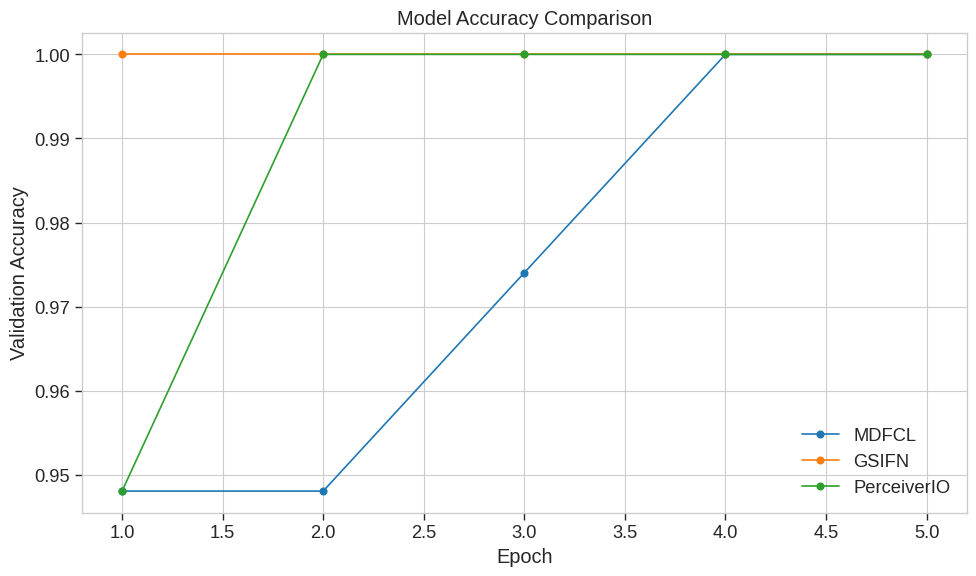

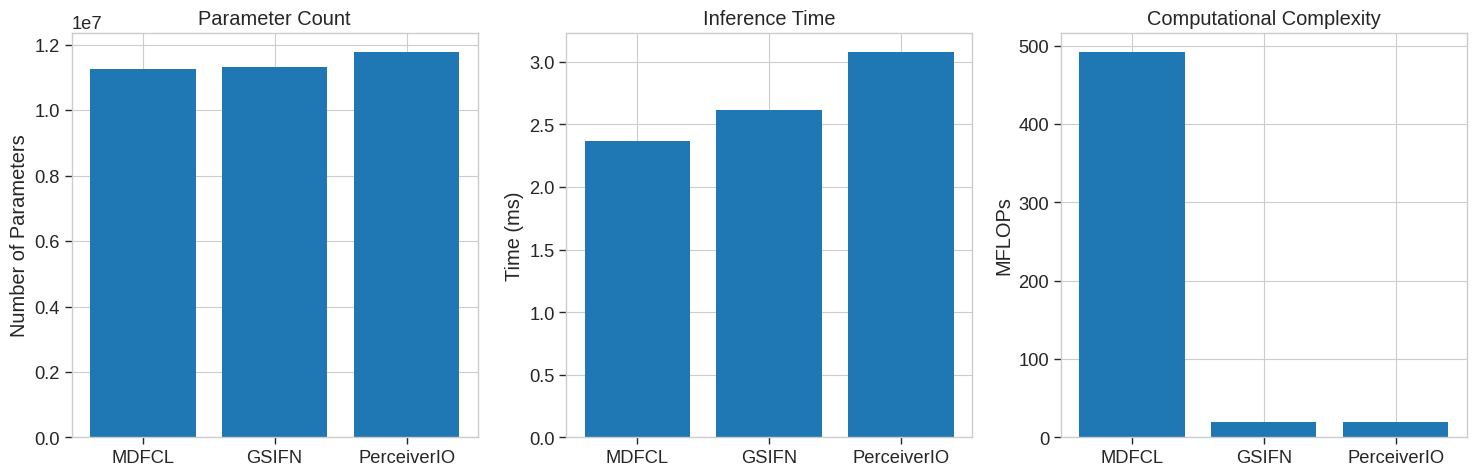

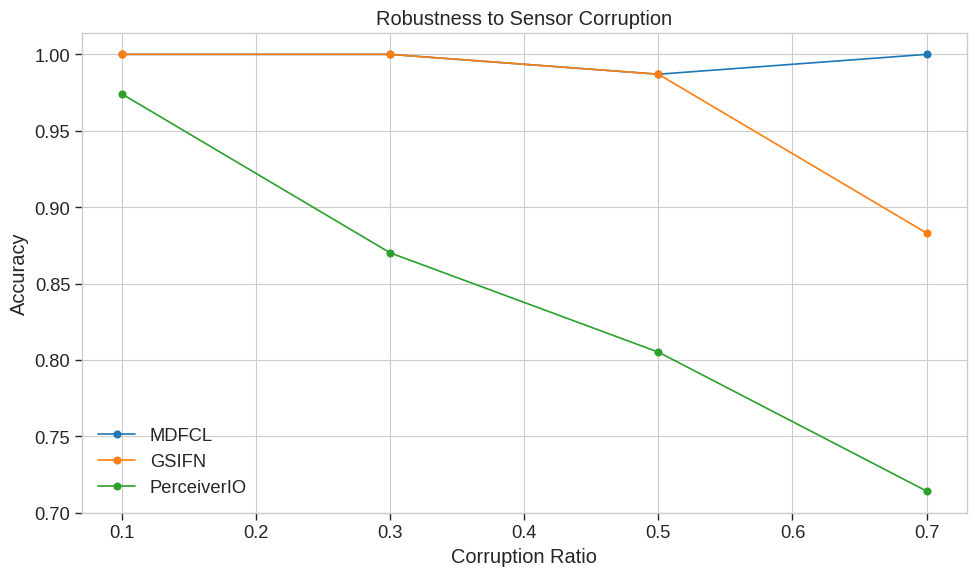

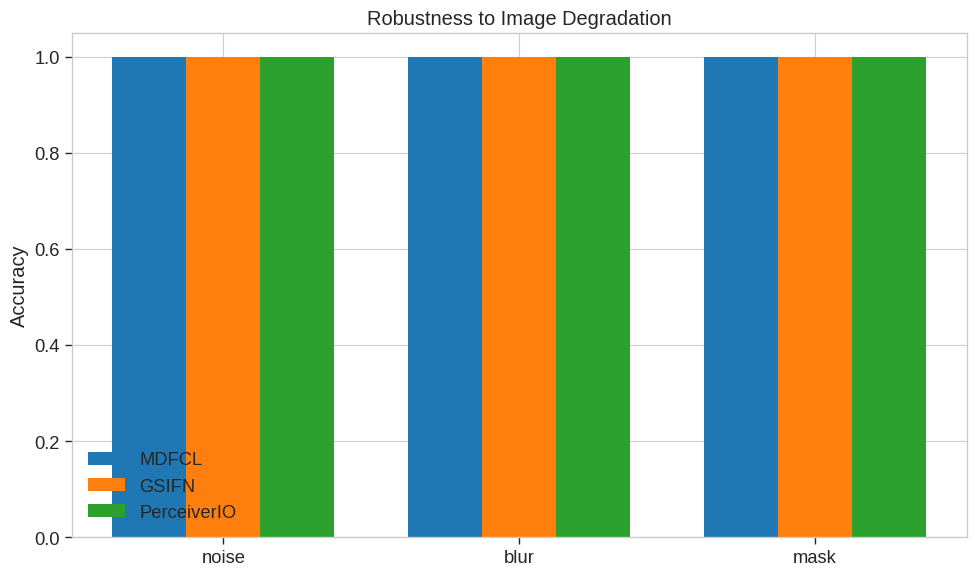

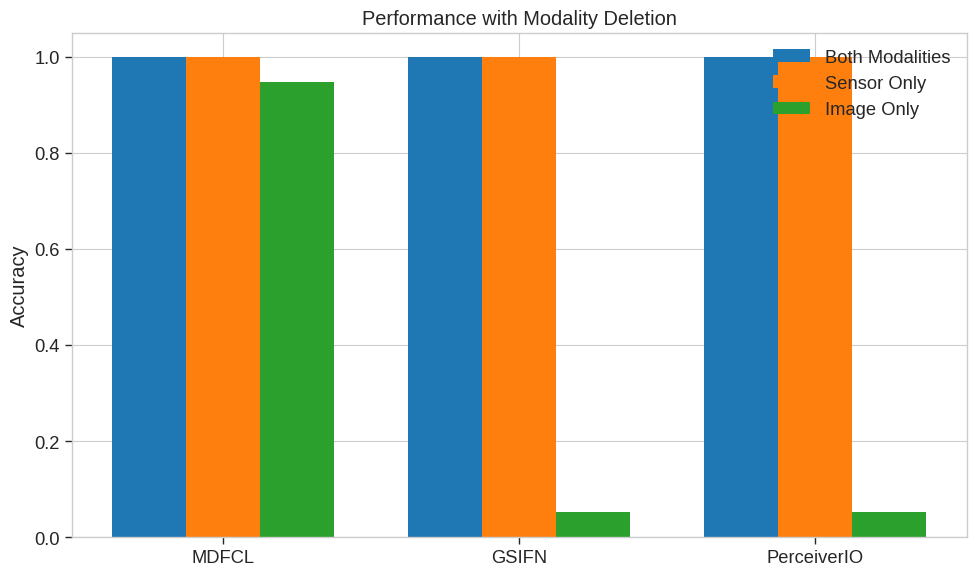

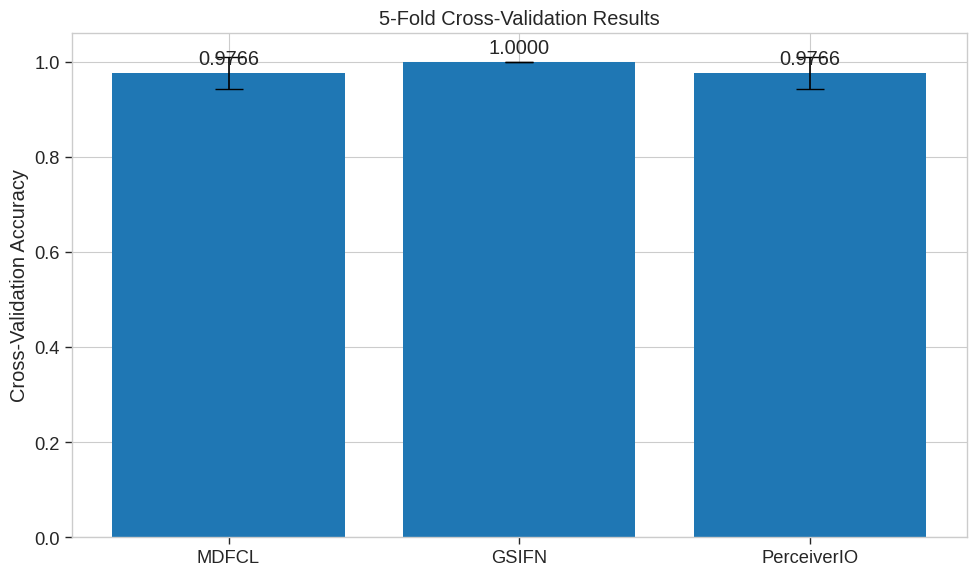

In [28]:
if __name__ == '__main__':
    main()